## Imports

In [1]:
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

## Read/Transform Data

In [2]:
VOCAB_SIZE = 16384
INPUT_LENGTH = 265
NUM_CLASSES = 5

In [3]:
# read data
df = pd.read_csv('cleaned-data.csv')

In [4]:
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Lyric,Genres
0,written kylie minogue stephen bray chorus wit...,Pop
1,head under water and they tell me to breathe e...,Pop/Rock; Pop
2,here comes santa claus here comes santa claus ...,Pop
3,tale dreadful a murdered father and a king dee...,Heavy Metal
4,you turned him down and baby you fall a little...,Pop


In [5]:
indexNames = []
for index, row in df.iterrows():
    if len(row.Genres.split("; "))>1:
        indexNames.append(index)
df = df.drop(indexNames)

In [6]:
x = np.array(df['Lyric'])
y = np.array(df['Genres'])

<AxesSubplot:>

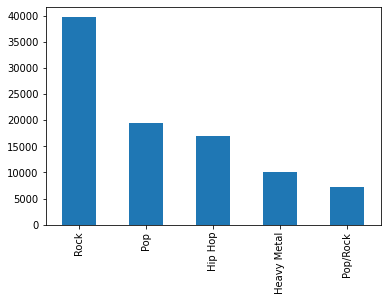

In [7]:
df['Genres'].value_counts().plot.bar()

In [8]:
# tokenizer to transform lyrics into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# updates internal vocabulary based on the lyrics
tokenizer.fit_on_texts(x)

# transform each text in x to a sequence of tokens
x = tokenizer.texts_to_sequences(x)

# pads/cuts sequences to the same length
x = pad_sequences(x, maxlen = INPUT_LENGTH)

# tokenizer to transform genres into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split='; ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# updates internal vocabulary based on the genres
tokenizer.fit_on_texts(y)

# transform each genre in y to an integer
y = tokenizer.texts_to_sequences(y)
y = np.array([elem[0]-1 for elem in y])

In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = split(x, y)

## Model

In [10]:
def LSTM_Model(features=256, dropout=0.9, neurons=256):
    model=Sequential()
    # Embedding layer
    model.add(Embedding(VOCAB_SIZE,features,input_length=INPUT_LENGTH))
    # Long Short Term Memory layer
    model.add(LSTM(neurons, dropout=dropout))
    # Output layer
    model.add(Dense(NUM_CLASSES,activation='sigmoid'))
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [11]:
model = LSTM_Model()
model.summary()

2022-07-04 19:52:16.490652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 19:52:17.722938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 19:52:17.723584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 19:52:17.756133: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 256)          4194304   
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 4,720,901
Trainable params: 4,720,901
Non-trainable params: 0
_________________________________________________________________


## Validation and Testing

In [ ]:
epochs = 3

results = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=epochs)

Epoch 1/3


2022-07-04 19:52:42.956153: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


1757/1757 [==============================] - 161s 81ms/step - loss: 1.1163 - accuracy: 0.4939 - val_loss: 0.9154 - val_accuracy: 0.5760
Epoch 2/3
   4/1757 [..............................] - ETA: 2:09 - loss: 0.9747 - accuracy: 0.5547

In [ ]:
plot_accuracy_comparison([results.history["accuracy"], results.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

In [ ]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

In [ ]:
model = LSTM_Model()
results = model.fit(np.concatenate((x_train,x_val)), np.concatenate((y_train,y_val)), epochs=epochs)
loss, acc = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

# show confusion matrix
y_pred=np.argmax(model.predict(x_test), axis=-1)
#plot_confusion_matrix(y_test, y_pred)

# show other metrics
print(classification_report(y_pred,y_test))

## Hyper-Parameter Selection

### Epochs

In [ ]:
model = LSTM_Model()
results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=10)

In [ ]:
plot_accuracy_comparison([results.history["accuracy"], results.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

In [ ]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

### Dropout Rate

In [ ]:
dropout_rates=[]
acc = []
loss = []

dp = 0
while dp <= 0.9:
    model = LSTM_Model(dropout=dp)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    dropout_rates.append(dp)
    dp += 0.1

In [ ]:
plot_accuracy_comparison(acc, "Learning Rate Comparison (Validation Accuracy)", dropout_rates)

In [ ]:
plot_loss_comparison(loss, "Learning Rate Comparison (Validation Loss)", dropout_rates)

### Features

In [ ]:
features=[]
acc = []
loss = []

f = 32
while f <= 512:
    model = LSTM_Model(features=f)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    features.append(f)
    f *= 2

In [ ]:
plot_accuracy_comparison(acc, "Learning Rate Comparison (Validation Accuracy)", features)

In [ ]:
plot_loss_comparison(loss, "Learning Rate Comparison (Validation Loss)", features)

### Neurons

In [ ]:
neurons=[]
acc = []
loss = []

n = 32
while n <= 512:
    model = LSTM_Model(neurons=n)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    neurons.append(n)
    n *= 2

In [ ]:
plot_accuracy_comparison(acc, "Learning Rate Comparison (Validation Accuracy)", neurons)

In [ ]:
plot_loss_comparison(loss, "Learning Rate Comparison (Validation Loss)", neurons)